# <center>Credit Default Project<center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


**Credit Default Project**

* [Обзор обучающего датасета](#review)
* [Анализ данных](#analysis)
* [Обработка пропусков](#missing)
* [Обработка выбросов](#outliers)
* [Обработка категориальных признаков](#catfeatures)
* [Отбор признаков](#featureselection)
* [Балансировка классов](#balance)
* [Подбор моделей, получение бейзлайна](#baseline)
* [Выбор наилучшей модели, настройка гиперпараметров](#setting)    
* [Проверка качества, борьба с переобучением](#qc)
* [Интерпретация результатов](#result)


**Загрузка библиотек**

In [1]:
import pandas as pd
import numpy as np
import pickle
import random
import re
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, classification_report, f1_score, precision_score, recall_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import catboost as catb

from eli5.sklearn import PermutationImportance
import eli5

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Пути к директориям и файлам**

In [2]:
DATA_ROOT = Path('./data/')
MODELS_PATH = Path('./models/')

# input
DATASET_PATH_TRAIN = DATA_ROOT / 'train.csv'
DATASET_PATH_TEST = DATA_ROOT / 'test.csv'
PREP_DATASET_PATH = DATA_ROOT / 'train_prep.csv'
SAMPLE_SUBMISSION = DATA_ROOT / 'sample_submission.csv'

# output
TRAIN_FULL_PATH = DATA_ROOT / 'train_full.csv'
TRAIN_PART_PATH = DATA_ROOT / 'train_part.csv'
VAL_PART_PATH = DATA_ROOT / 'val_part.csv'
FINAL_SUBM_PATH = DATA_ROOT / 'CD_VK_submission.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

**Загрузка данных**

In [3]:
df = pd.read_csv(DATASET_PATH_TRAIN)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df_test = pd.read_csv(DATASET_PATH_TEST)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [5]:
print(df.shape)
print(df_test.shape)

(7500, 17)
(2500, 16)


In [6]:
print(df.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Приведение типов данных**

In [7]:
def dtype(df):
    for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
        df[colname] = df[colname].astype(str)
    df['Years in current job'].replace('nan', '0 years', inplace=True) 
    df['Years in current job'] = df['Years in current job'].str.extract('(\d+)').astype(int)
    
dtype(df)

In [8]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job              int32
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Обзор обучающего датасета<a class="anchor" id="review"></a>

**Обзор целевой переменной**

In [9]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [10]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00,7500.00
mean,1366391.72,5.66,0.03,11.13,18.32,945153.73,0.17,34.69,0.12,11873177.45,289833.24,18314.45,1151.09,0.28
std,845339.20,3.65,0.27,4.91,7.04,16026216.67,0.50,21.69,0.35,31926122.97,317871.38,11926.76,1604.45,0.45
min,164597.00,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,844341.00,2.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,711.00,0.00
50%,1168386.00,6.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00,0.00
75%,1640137.00,10.00,0.00,14.00,21.80,793501.50,0.00,50.00,0.00,519882.00,360406.25,23818.00,743.00,1.00
max,10149344.00,10.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00,1.00


**Обзор номинативных признаков**

In [11]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



### Анализ данных<a class="anchor" id="analysis"></a>

**Матрица корреляций**

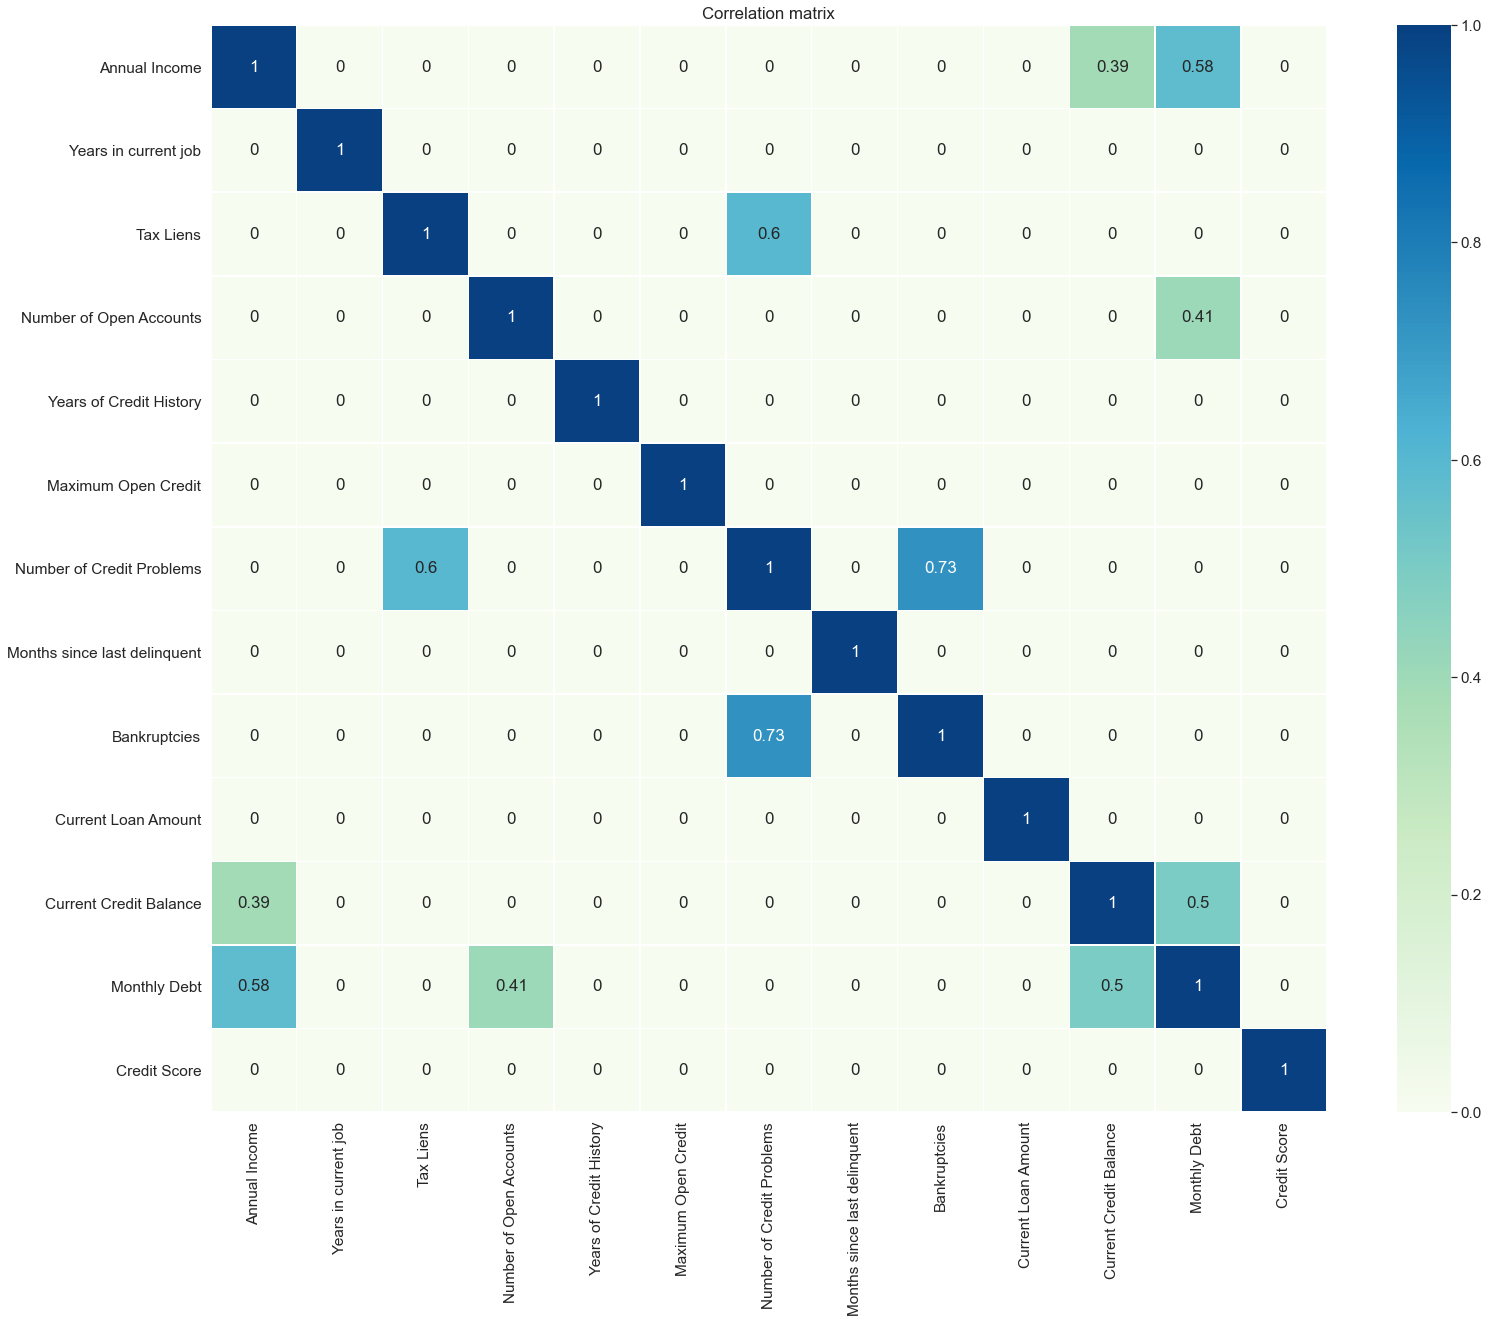

In [12]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Высокая корреляция только между банкротствами и количеством проблем с кредитами.

### Обработка пропусков<a class="anchor" id="missing"></a>

In [13]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [14]:
def missing(df):
    for column in ['Annual Income', 'Months since last delinquent']:
        df[column].fillna(df[column].mean(), inplace=True)
    df['Credit Score'].fillna(-1, inplace=True)

missing(df)

### Обработка выбросов<a class="anchor" id="outliers"></a>

In [15]:
def outliers(df):
    cla_mean = df[df['Current Loan Amount'] < 9999999.0]['Current Loan Amount'].mean()
    df.loc[(df['Current Loan Amount'] >= 9999999.0), 'Current Loan Amount'] = cla_mean

outliers(df)

### Обработка категориальных признаков<a class="anchor" id="catfeatures"></a>

In [16]:
CAT_FEATURES = df.select_dtypes(include='object').columns.tolist()

df[CAT_FEATURES].nunique()

Home Ownership     4
Purpose           15
Term               2
dtype: int64

In [17]:
df['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [18]:
def bin_to_numbers(df):
    #Term
    term_to_numbers = {'Short Term': 0, 'Long Term': 1}
    df['Term'] = df['Term'].replace(term_to_numbers)
    #Home Ownership
    ho_to_numbers = {'Have Mortgage': 0, 'Home Mortgage': 0, 'Rent': 1, 'Own Home': 1}
    df['Home Ownership'] = df['Home Ownership'].replace(ho_to_numbers)
    #Purpose
    df.drop('Purpose', axis=1, inplace=True)
    return df

bin_to_numbers(df)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,1,482087.00,0,0.00,11.00,26.30,685960.00,1.00,34.69,1.00,0,309024.39,47386.00,7914.00,749.00,0
1,1,1025487.00,10,0.00,15.00,15.30,1181730.00,0.00,34.69,0.00,1,264968.00,394972.00,18373.00,737.00,1
2,0,751412.00,8,0.00,11.00,35.00,1182434.00,0.00,34.69,0.00,0,309024.39,308389.00,13651.00,742.00,0
3,1,805068.00,6,0.00,8.00,22.50,147400.00,1.00,34.69,1.00,0,121396.00,95855.00,11338.00,694.00,0
4,1,776264.00,8,0.00,13.00,13.60,385836.00,1.00,34.69,0.00,0,125840.00,93309.00,7180.00,719.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,1,402192.00,1,0.00,3.00,8.50,107866.00,0.00,34.69,0.00,0,129360.00,73492.00,1900.00,697.00,0
7496,0,1533984.00,1,0.00,10.00,26.50,686312.00,0.00,43.00,0.00,1,444048.00,456399.00,12783.00,7410.00,1
7497,1,1878910.00,6,0.00,12.00,32.10,1778920.00,0.00,34.69,0.00,0,309024.39,477812.00,12479.00,748.00,0
7498,0,1366391.72,0,0.00,21.00,26.50,1141250.00,0.00,34.69,0.00,0,615274.00,476064.00,37118.00,-1.00,0


### Отбор признаков<a class="anchor" id="featureselection"></a>

In [19]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
                     'Months since last delinquent', 'Bankruptcies', 'Term', 'Home Ownership', 'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score']

**Корреляция с базовыми признаками**

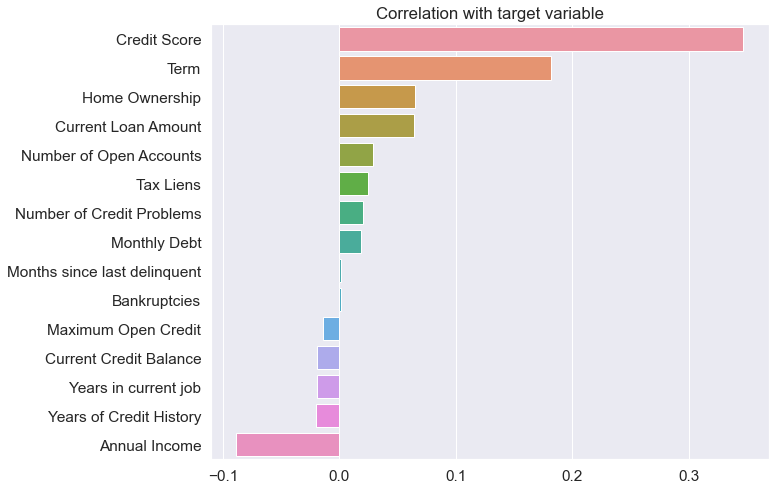

In [20]:
corr_with_target = df[FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Сильная положительная корреляция с целевой переменной у признаков Credit Score и Term, а так же отрицательная корреляция
у признака Annual Income.

<AxesSubplot:xlabel='Credit Default', ylabel='Credit Score'>

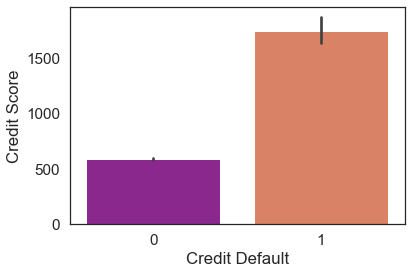

In [21]:
sns.set_style('white')

sns.barplot(x ='Credit Default', y ='Credit Score', data = df, palette ='plasma')

<AxesSubplot:xlabel='Credit Default', ylabel='Term'>

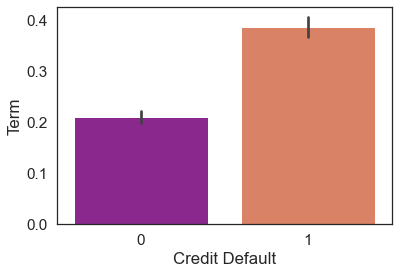

In [22]:
sns.set_style('white')

sns.barplot(x ='Credit Default', y ='Term', data = df, palette ='plasma')

In [23]:
features = ['Annual Income',
             'Years in current job',
             'Tax Liens',
             'Number of Open Accounts',
             'Years of Credit History',
             'Maximum Open Credit',
             'Number of Credit Problems',
             'Months since last delinquent',
             'Bankruptcies',
             'Term',
             'Current Loan Amount',
             'Current Credit Balance',
             'Monthly Debt',
             'Home Ownership',
             'Credit Score',
            ]

In [24]:
train, test = train_test_split(df,
                               test_size=0.3,
                               shuffle=True,
                               stratify=df['Credit Default'],
                               random_state=12)

In [25]:
X_train = train[features]
y_train = train['Credit Default']

X_test = test[features]
y_test = test['Credit Default']

In [26]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

pred_train = xgb.predict(X_train)
pred_test = xgb.predict(X_test)

print("TRAIN\n", round(f1_score(y_train, pred_train), 3))
print("TEST\n", round(f1_score(y_test, pred_test), 3))

[11:22:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN
 0.94
TEST
 0.445


Модель очень сильно переобучивается, но выбор признаков слабо на это влияет.

### Балансировка классов<a class="anchor" id="balance"></a>

In [27]:
#Масштабируем данные
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [28]:
#Сохранение модели для масштабирования данных
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

Провел множество тестов с tomek, smote, остановился на стандартной балансировке классов от CatBoost.

In [29]:
#Разбиение на train, val
# df[NUM_FEATURE_NAMES] = scaler.transform(df[NUM_FEATURE_NAMES])

X = df[NUM_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

### Подбор моделей, получение бейзлайна<a class="anchor" id="baseline"></a>

In [30]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def data_prepare(df):
    dtype(df)
    missing(df)
    outliers(df)
    bin_to_numbers(df)
    reduce_mem_usage(df)
    return df

def get_scores(report_df, model, X_val, y_val, name):

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_val,
                                      model.predict_proba(X_val)[:, 1])
    report['F1'] = f1_score(y_test, model.predict(X_val))
    report['precision_0'] = precision_score(
        y_test, model.predict(X_val), pos_label=0)
    report['precision_1'] = precision_score(
        y_test, model.predict(X_val), pos_label=1)
    report['recall_0'] = recall_score(
        y_test, model.predict(X_val), pos_label=0)
    report['recall_1'] = recall_score(
        y_test, model.predict(X_val), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

**Сохранение обучающего и валидационного датасетов**

In [31]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)

In [32]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
val.to_csv(VAL_PART_PATH, index=False, encoding='utf-8')

Попробовал все модели, а так же Voting и Stacking нескольких моделей, но лучше всего себя показал CatBoost.

**CatBoost**

In [33]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [34]:
model_catb = CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val))

print(model_catb.best_score_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'Recall:use_weights=false': 0.6727518593644354, 'Logloss': 0.5210455292148121, 'F1': 0.7155453755137337, 'Precision:use_weights=false': 0.5596175478065242, 'Precision:use_weights=true': 0.76415287934696, 'Recall:use_weights=true': 0.6727518593644354}, 'validation': {'Recall:use_weights=false': 0.6088328075709779, 'Logloss': 0.5652427086922375, 'F1': 0.6454614352663851, 'Precision:use_weights=false': 0.4939434724091521, 'Precision:use_weights=true': 0.7133574657806584, 'Recall:use_weights=true': 0.6088328075709779}}


In [35]:
y_pred_proba = model_catb.predict_proba(X_val)[:, 1]
y_pred_catb = model_catb.predict(X_val)

In [36]:
df_report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])

df_report['ROC-AUC'] = roc_auc_score(y_val, y_pred_proba)
df_report['F1'] = f1_score(y_val, y_pred_catb)
df_report['precision_0'] = precision_score(y_val, y_pred_catb, pos_label=0)
df_report['recall_0'] = recall_score(y_val, y_pred_catb, pos_label=0)
df_report['precision_1'] = precision_score(y_val, y_pred_catb, pos_label=1)
df_report['recall_1'] = recall_score(y_val, y_pred_catb, pos_label=1)

df_report.index = ['CatBoost']

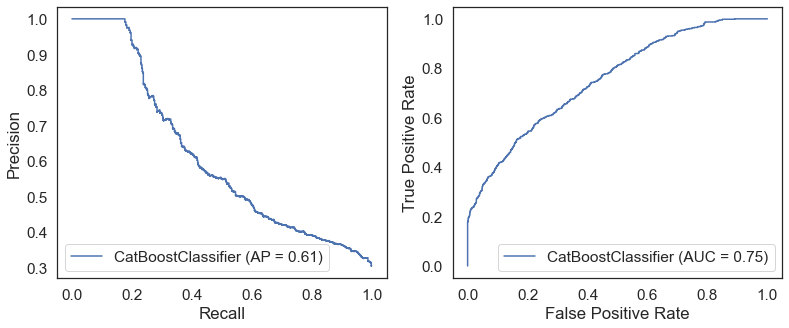

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(model_catb, X_val, y_val, ax=ax1)
plot_roc_curve(model_catb, X_val, y_val, ax=ax2);

In [38]:
df_report

,ROC-AUC,F1,precision_0,recall_0,precision_1,recall_1
CatBoost,0.75,0.54,0.83,0.76,0.49,0.59


**Permutation Importance**

In [39]:
df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,1,482087.00,0,0.00,11.00,26.30,685960.00,1.00,34.69,1.00,0,309024.39,47386.00,7914.00,749.00,0
1,1,1025487.00,10,0.00,15.00,15.30,1181730.00,0.00,34.69,0.00,1,264968.00,394972.00,18373.00,737.00,1
2,0,751412.00,8,0.00,11.00,35.00,1182434.00,0.00,34.69,0.00,0,309024.39,308389.00,13651.00,742.00,0
3,1,805068.00,6,0.00,8.00,22.50,147400.00,1.00,34.69,1.00,0,121396.00,95855.00,11338.00,694.00,0
4,1,776264.00,8,0.00,13.00,13.60,385836.00,1.00,34.69,0.00,0,125840.00,93309.00,7180.00,719.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,1,402192.00,1,0.00,3.00,8.50,107866.00,0.00,34.69,0.00,0,129360.00,73492.00,1900.00,697.00,0
7496,0,1533984.00,1,0.00,10.00,26.50,686312.00,0.00,43.00,0.00,1,444048.00,456399.00,12783.00,7410.00,1
7497,1,1878910.00,6,0.00,12.00,32.10,1778920.00,0.00,34.69,0.00,0,309024.39,477812.00,12479.00,748.00,0
7498,0,1366391.72,0,0.00,21.00,26.50,1141250.00,0.00,34.69,0.00,0,615274.00,476064.00,37118.00,-1.00,0


In [40]:
perm = PermutationImportance(model_catb, scoring='f1').fit(X_val, y_val)

In [41]:
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.1050 ± 0.0113,Credit Score
0.0447 ± 0.0135,Term
0.0322 ± 0.0099,Current Credit Balance
0.0190 ± 0.0106,Maximum Open Credit
0.0165 ± 0.0062,Annual Income
0.0127 ± 0.0077,Current Loan Amount
0.0091 ± 0.0023,Home Ownership
0.0036 ± 0.0064,Months since last delinquent
0.0036 ± 0.0041,Years in current job
0.0018 ± 0.0014,Number of Credit Problems


### Настройка гиперпараметров<a class="anchor" id="setting"></a>

In [42]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':20,
}
model_catb = CatBoostClassifier(**frozen_params)

In [43]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [44]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [45]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5773217396
bestIteration = 0

0:	loss: 0.5773217	best: 0.5773217 (0)	total: 418ms	remaining: 5.85s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5773217396
bestIteration = 0

1:	loss: 0.5773217	best: 0.5773217 (0)	total: 522ms	remaining: 3.39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5773217396
bestIteration = 0

2:	loss: 0.5773217	best: 0.5773217 (0)	total: 631ms	remaining: 2.52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5773217396
bestIteration = 0

3:	loss: 0.5773217	best: 0.5773217 (0)	total: 733ms	remaining: 2.02s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5773217396
bestIteration = 0

4:	loss: 0.5773217	best: 0.5773217 (0)	total: 809ms	remaining: 1.62s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.597889168
bestIteration = 2

5:	loss: 0.5978892	best: 0.5978892 (5)	total: 925ms	remaining: 1.39s

In [46]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
49,49,0.64,0.01,0.70,0.02,0.58,0.01,0.54,0.00
43,43,0.64,0.01,0.70,0.02,0.58,0.00,0.55,0.01
47,47,0.64,0.01,0.70,0.01,0.58,0.01,0.55,0.00
48,48,0.64,0.01,0.70,0.02,0.58,0.01,0.55,0.00
39,39,0.64,0.01,0.69,0.02,0.58,0.00,0.56,0.01


### Проверка качества, борьба с переобучением<a class="anchor" id="qc"></a>

In [47]:
def get_classification_report(y_train_true, y_train_pred, y_val_true, y_val_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_val_true, y_val_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_val_true, y_val_pred))

In [48]:
def evaluate_preds(model, X_train, X_val, y_train, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    get_classification_report(y_train, y_train_pred, y_val, y_val_pred)

In [49]:
final_model = CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     reg_lambda=.5,
                                     n_estimators=100,
                                     max_depth=5,
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                    )
final_model.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val))

evaluate_preds(final_model, X_train, X_val, y_train, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3771
           1       0.52      0.62      0.57      1479

    accuracy                           0.73      5250
   macro avg       0.68      0.70      0.69      5250
weighted avg       0.75      0.73      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1616
           1       0.48      0.58      0.52       634

    accuracy                           0.70      2250
   macro avg       0.65      0.67      0.65      2250
weighted avg       0.72      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1221  395
1                269  365


In [50]:
perm_final = PermutationImportance(final_model, scoring='f1').fit(X_val, y_val)

In [51]:
eli5.show_weights(perm_final, feature_names=X_test.columns.tolist())

Weight,Feature
0.1080 ± 0.0128,Credit Score
0.0417 ± 0.0179,Term
0.0176 ± 0.0113,Current Credit Balance
0.0076 ± 0.0069,Maximum Open Credit
0.0074 ± 0.0118,Annual Income
0.0069 ± 0.0100,Current Loan Amount
0.0019 ± 0.0033,Number of Open Accounts
0.0017 ± 0.0057,Monthly Debt
0.0014 ± 0.0034,Months since last delinquent
0.0008 ± 0.0031,Years of Credit History


In [52]:
#Сохранение модели
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

**Submission**

In [53]:
df_test = data_prepare(df_test)

Memory usage of dataframe is 0.28 MB
Memory usage after optimization is: 0.12 MB
Decreased by 56.0%


In [54]:
df_test

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,1,1366921.62,4,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,0,162470.00,105906.00,6813.00,-1.00
1,1,231838.00,1,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,0,78298.00,46037.00,2318.00,699.00
2,0,1152540.00,3,0.00,10.00,13.70,204600.00,0.00,34.18,0.00,0,200178.00,146490.00,18729.00,7260.00
3,0,1220313.00,10,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,0,217382.00,213199.00,27559.00,739.00
4,0,2340952.00,6,0.00,11.00,23.60,1207272.00,0.00,34.18,0.00,1,777634.00,425391.00,42605.00,706.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0,1020053.00,10,0.00,14.00,29.10,559152.00,1.00,68.00,1.00,0,312891.22,162735.00,15046.00,745.00
2496,0,1366921.62,2,0.00,15.00,17.00,1737780.00,0.00,77.00,0.00,0,468512.00,1439269.00,32996.00,-1.00
2497,0,1171806.00,2,0.00,48.00,12.80,1706430.00,0.00,34.18,0.00,0,430496.00,676438.00,36912.00,695.00
2498,1,723520.00,10,0.00,14.00,28.80,945780.00,0.00,34.18,0.00,0,257774.00,391248.00,13506.00,744.00


In [55]:
submit = pd.read_csv(SAMPLE_SUBMISSION)

In [56]:
submit['Credit Default'] = final_model.predict(df_test)

In [57]:
submit.to_csv(FINAL_SUBM_PATH, index=False)